In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv("/content/final.csv")

In [ ]:
df.head()

,text,label
0,"At about 8:00 pm on 10.09.1996, the\r\ndecease...",murder
1,"between 26th and 27th November, 2000 when all ...",murder
2,"The case of the prosecution in brief is that, ...",murder
3,I submit that my wife burnt to death this\r\ne...,murder
4,They entered the house and saw\r\nParamjit Sin...,murder


In [ ]:
df.label.describe()

count        348
unique         3
top       murder
freq         149
Name: label, dtype: object

In [ ]:
df['target']=df.label.map({"murder":0,"kidnapping":1,"sexual offense":2})

In [ ]:
df.columns=['text','label','target']

In [ ]:
df.target.astype(int)

0      0
1      0
2      0
3      0
4      0
      ..
343    0
344    0
345    0
346    0
347    0
Name: target, Length: 348, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.text,df.target, test_size = 0.2, stratify = df.target,random_state = 42)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=171,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 171, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(278, 171) (70, 171)


In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

[=================================================-] 99.9% 375.7/376.1MB downloaded


In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

In [ ]:
print(gensim_weight_matrix.shape)
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional,GRU
import tensorflow
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

(10000, 300)


In [ ]:
EMBEDDING_DIM = 300 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(300,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(300,return_sequences=False)))
model_gensim.add(Dense(3, activation = 'softmax'))
model_gensim.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',metrics =['accuracy'])

In [ ]:
model_gensim.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 300)          3000000   
                                                                 
 dropout (Dropout)           (None, 171, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 171, 600)         1083600   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 171, 600)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 171, 800)         2404800   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 171, 800)          0

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 60, batch_size = 100, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )

Epoch 1/60
3/3 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.5576 
Epoch 1: val_accuracy improved from -inf to 0.37143, saving model to ./model_gensim.h5
3/3 [==============================] - 93s 25s/step - loss: 1.0376 - accuracy: 0.5576 - val_loss: 1.2044 - val_accuracy: 0.3714
Epoch 2/60
3/3 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.5576 
Epoch 2: val_accuracy improved from 0.37143 to 0.70000, saving model to ./model_gensim.h5
3/3 [==============================] - 70s 23s/step - loss: 0.8716 - accuracy: 0.5576 - val_loss: 0.6861 - val_accuracy: 0.7000
Epoch 3/60
3/3 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.7338 
Epoch 3: val_accuracy improved from 0.70000 to 0.80000, saving model to ./model_gensim.h5
3/3 [==============================] - 68s 23s/step - loss: 0.6153 - accuracy: 0.7338 - val_loss: 0.5509 - val_accuracy: 0.8000
Epoch 4/60
3/3 [==============================] - ETA: 0s - loss: 0.42

In [ ]:
model_gensim.evaluate(X_test_pad, y_test) 

3/3 [==============================] - 0s 45ms/step - loss: 0.6573 - accuracy: 0.8429


[0.6573021411895752, 0.8428571224212646]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

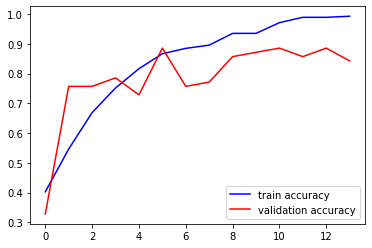

In [ ]:
plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

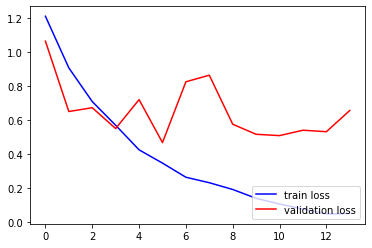

In [ ]:
plt.plot(history_gensim.history['loss'],c='b',label='train loss')
plt.plot(history_gensim.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
new_complaint = ['On 6.11.1995, Nasima Begum (PW.1), aged about 16 years filed a complaint alleging that on that day while she was going to attend her tuition alongwith her friend Nilufa Khatun, she met the appellant on the way who suddenly came and forcibly caught hold of her hair and planted a kiss, resultantly, she suffered a cut over her lower lip and started bleeding.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=171,padding='post')
pred = model_gensim.predict(padded)
labels = ['murder','kidnapping','sexual offense']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 3s 3s/step
[[1.0568783e-02 5.2282053e-06 9.8942602e-01]] sexual offense


In [ ]:
from sklearn.metrics import classification_report

y_pred=model_gensim.predict(X_test_pad)
predicted = np.argmax(y_pred, axis=1)
report = classification_report(y_test, predicted)
print(report)

3/3 [==============================] - 0s 90ms/step
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        30
           1       0.73      0.80      0.76        10
           2       0.92      0.77      0.84        30

    accuracy                           0.84        70
   macro avg       0.82      0.83      0.82        70
weighted avg       0.85      0.84      0.84        70

